![image](../data/images/banner.png)


# **Taller 1**

- **Integrante 1:** Javier Muñóz
- **Integrante 2:** Gina E. Posada

### **Problemática**:
En un entorno clínico, los profesionales de la salud enfrentan el desafío de interpretar los resultados de las pruebas médicas de manera rápida y precisa para tomar decisiones informadas sobre el tratamiento y el seguimiento de los pacientes. Sin embargo, debido a la gran cantidad de datos y la complejidad de las condiciones médicas, esta tarea resulta muy tediosa.

Problema específico: Los resultados de las pruebas médicas, que se describen como "Normal," "Anormal," o "Inconcluso," deben ser interpretados con precisión para determinar la necesidad de seguimiento adicional o tratamiento especializado.
        
Los datos y el diccionario de datos lo pueden encontrar [acá](https://www.kaggle.com/datasets/prasad22/healthcare-dataset/data).

&nbsp;

### **Preguntas:**
1. Realice el debido preprocesamiento de los datos, feature engineering, EDA, Encoding Techniques, etc... Dentro de un pipeline que almacene todo el proceso.

2. Genere un modelo MLP base de predicción. Confirme si su modelo generaliza bien, o si presenta sobreajuste o subajuste. Si es alguna de las dos últimas opciones, ¿qué opciones propone para que la red MLP generalice mejor?

3. Realice una búsqueda de hiperparámetros para encontrar el mejor modelo. Documentarlo en un cuadro comparativon con el modelo base del punto anterior.

4. ¿Cómo podemos mejorar el tiempo de entrenamiento de los modelos? ¿Que es el EarlyStopping y cómo se puede automatizar utilizando callback? Está pregunta es más teórica, pero pueden incluir código si lo creen necesario.

### NOTA IMPORTANTE
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `taller_1_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

# 1. Pipeline: Definición del análisis

In [1]:
import os
from pathlib import Path
import random
import time

random_state = random.randint(1,999)
display(random_state)

# COnfiguraciones para tensorflow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


811

In [2]:
import kaggle
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import plot_model
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from ydata_profiling import ProfileReport

In [3]:
# Configuracion
%matplotlib inline
pd.options.display.max_columns = 999
ohe = OneHotEncoder(sparse_output=False)

## 1.0. Datos

In [4]:
kaggle.api.dataset_download_files('prasad22/healthcare-dataset', path='../data/raw/data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/prasad22/healthcare-dataset


In [5]:
directory = Path("../data/raw/data")
file_name = next(directory.iterdir(), None)
str(file_name)

'../data/raw/data/healthcare_dataset.csv'

In [6]:
df = pd.read_csv(file_name)
columnas_analisis = df.columns.to_list()
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [7]:
# Division en entrenamiento/prueba
df_train, df_test = train_test_split(df, test_size=0.2 , random_state=33)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
21883,jOSeph dORsEY,71,Female,A+,Diabetes,2021-09-26,Angela Wright,Meyers-Phillips,Cigna,40284.030173,283,Urgent,2021-10-02,Aspirin,Inconclusive
29945,MONicA KiNg,44,Male,A+,Arthritis,2019-07-26,Ann Trujillo,Inc Rodriguez,Blue Cross,7593.331495,264,Elective,2019-08-13,Paracetamol,Abnormal


<class 'pandas.core.frame.DataFrame'>
Index: 44400 entries, 21883 to 23572
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                44400 non-null  object 
 1   Age                 44400 non-null  int64  
 2   Gender              44400 non-null  object 
 3   Blood Type          44400 non-null  object 
 4   Medical Condition   44400 non-null  object 
 5   Date of Admission   44400 non-null  object 
 6   Doctor              44400 non-null  object 
 7   Hospital            44400 non-null  object 
 8   Insurance Provider  44400 non-null  object 
 9   Billing Amount      44400 non-null  float64
 10  Room Number         44400 non-null  int64  
 11  Admission Type      44400 non-null  object 
 12  Discharge Date      44400 non-null  object 
 13  Medication          44400 non-null  object 
 14  Test Results        44400 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 5.4+

None

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
8814,AlICE jOhnsOn,58,Female,A-,Arthritis,2020-08-09,Christine Harper,"Davenport, Baker Robinson and",Aetna,9847.650755,391,Emergency,2020-09-07,Paracetamol,Normal
37214,SUSAN mIChAEl,74,Female,AB+,Arthritis,2019-10-08,Scott Peterson,Inc Lester,Blue Cross,29035.561479,362,Emergency,2019-10-16,Penicillin,Normal


<class 'pandas.core.frame.DataFrame'>
Index: 11100 entries, 8814 to 32850
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                11100 non-null  object 
 1   Age                 11100 non-null  int64  
 2   Gender              11100 non-null  object 
 3   Blood Type          11100 non-null  object 
 4   Medical Condition   11100 non-null  object 
 5   Date of Admission   11100 non-null  object 
 6   Doctor              11100 non-null  object 
 7   Hospital            11100 non-null  object 
 8   Insurance Provider  11100 non-null  object 
 9   Billing Amount      11100 non-null  float64
 10  Room Number         11100 non-null  int64  
 11  Admission Type      11100 non-null  object 
 12  Discharge Date      11100 non-null  object 
 13  Medication          11100 non-null  object 
 14  Test Results        11100 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 1.4+ 

None

Text(0.5, 1.0, 'Distribución de Resultados de Prueba en Conjunto de Entrenamiento y Prueba')

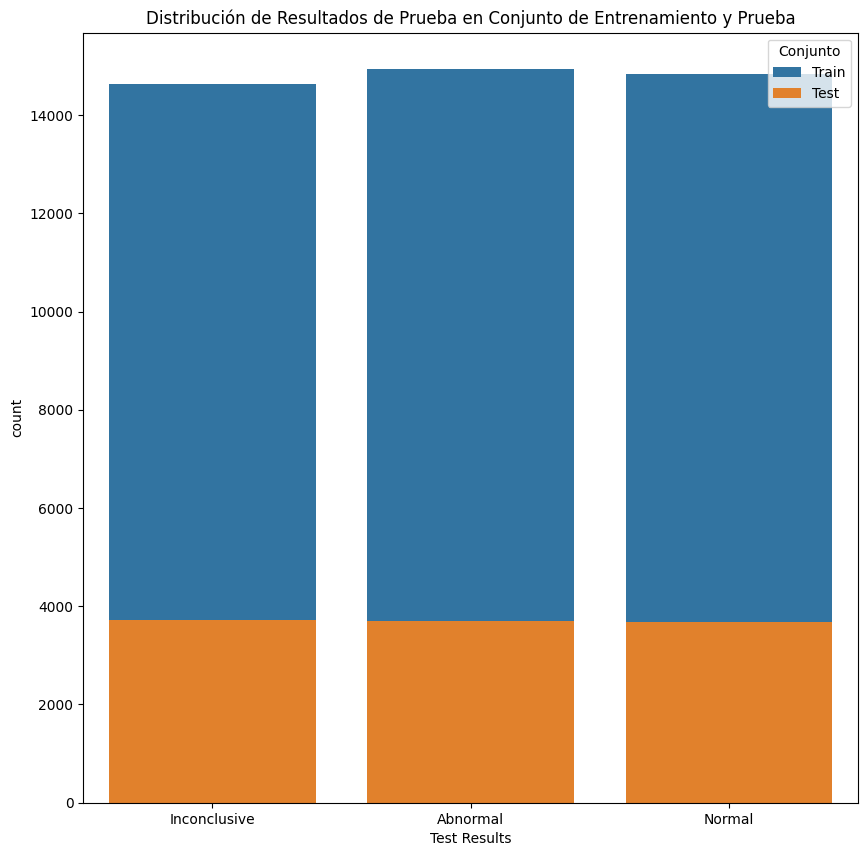

In [8]:
display(df_train.head(2))
display(df_train.info())
display(df_test.head(2))
display(df_test.info())
plt.figure(figsize=(10,10))
sns.countplot(df_train, x="Test Results", label='Train')
sns.countplot(df_test, x="Test Results", label='Test')
plt.legend(title='Conjunto')
plt.title("Distribución de Resultados de Prueba en Conjunto de Entrenamiento y Prueba")

La gráfica indica que los conjuntos de entrenamiento y prueba tienen una distribución bien balanceada y consistente de los resultados de pruebas, lo que es un buen indicador para entrenar y evaluar un modelo de manera equitativa en las clases de respuesta: Normal, Anormal y No concluyentes.

## 1.1. Preprocesamiento

## 1.2. Revisión datos (EDA)

In [9]:
profile = ProfileReport(df, title='Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(f"Filas duplicadas:\n{df.duplicated().sum()}")

Filas duplicadas:
534


In [11]:
# Eliminar duplicados del DataFrame
df.drop_duplicates(inplace = True)

In [12]:
df.duplicated().sum()

0

In [13]:
# Conteo de nulos
display(df_train.isnull().sum())
display(print("\n"))
display(df_test.isnull().sum())

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

None

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

In [14]:
# Determinar variables con alta cardinalidad
columnas_por_eliminar = []
cambiar_tipos_columnas = []
for col in df.select_dtypes(include=['object']).columns:
    print(f"Frecuencia de valores en '{col}':")
    cuantos_valores = df[col].value_counts(dropna=False)
    print(cuantos_valores)
    
    # Calcular porcentaje de valores únicos
    num_unique = df[col].nunique()
    total_values = df[col].size
    percent_unique = (num_unique / total_values) * 100
    if percent_unique > 20:
        columnas_por_eliminar.append(col)
    else:
        cambiar_tipos_columnas.append(col)
    print(f"\nPorcentaje de valores únicos en '{col}': {percent_unique:.2f}%\n")

display(print(f"Columnas con alta cardinalidad o por eliminar: {columnas_por_eliminar}"))
display(print(f"Columnas por tipear como categoricas: {cambiar_tipos_columnas}"))

Frecuencia de valores en 'Name':
Name
DAvId muNoZ          3
kaTheRIne WeBSTer    2
mICHael aNdERSon     2
DaVID caLhouN        2
MELiSsA COloN        2
                    ..
dUstin blaCKwELl     1
MARc CLaRK           1
sTEphen AyaLa        1
ThOMaS torreS        1
HARoLD ACOSTa        1
Name: count, Length: 49992, dtype: int64

Porcentaje de valores únicos en 'Name': 90.95%

Frecuencia de valores en 'Gender':
Gender
Male      27496
Female    27470
Name: count, dtype: int64

Porcentaje de valores únicos en 'Gender': 0.00%

Frecuencia de valores en 'Blood Type':
Blood Type
A-     6898
A+     6896
B+     6885
AB+    6882
AB-    6874
B-     6872
O+     6855
O-     6804
Name: count, dtype: int64

Porcentaje de valores únicos en 'Blood Type': 0.01%

Frecuencia de valores en 'Medical Condition':
Medical Condition
Arthritis       9218
Diabetes        9216
Hypertension    9151
Obesity         9146
Cancer          9140
Asthma          9095
Name: count, dtype: int64

Porcentaje de valores únic

None

Columnas por tipear como categoricas: ['Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Insurance Provider', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


None

["Name", "Doctor", "Hospital"]: son variables con alta cardinalidad. 
Es necesario eliminarlas ya que aumentan la dimensionalidad y complejidad del modelo acompañado del elevado coste computacional. Por otra parte, estas variables no parecen explicar el fenomeno del análisis, dado que la interpretación de los resultados de las pruebas médicas son ajenos a las descripciones que hacen del paciente estas caracteristicas.

In [15]:
# Crear una caracteristica para el total de días de permanencia del paciente
df_copy = df.copy()
df_copy["Admission Duration"] = (
    pd.to_datetime(df['Discharge Date'], format='%Y-%m-%d')
    - pd.to_datetime(df['Date of Admission'], format='%Y-%m-%d')
)

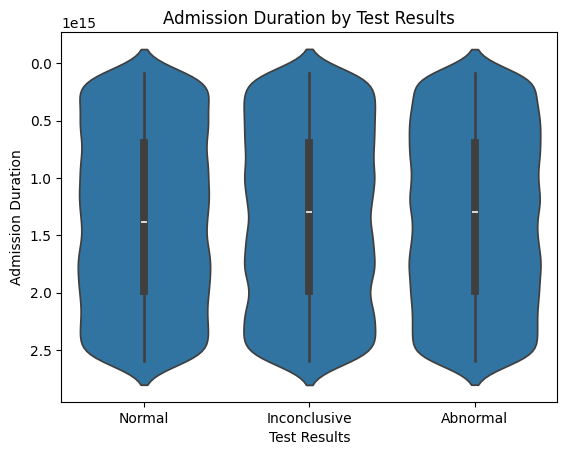

In [16]:
# Distribución de los resultados de acuerdo a los días de permanencia del paciente
sns.violinplot(x='Test Results', y='Admission Duration', data=df_copy)
plt.title('Admission Duration by Test Results')
plt.show()

La gráfica indica que la duración de la permanencia de los pacientes no parece variar de manera significativa según los resultados de las pruebas médicas. **Por lo que se ha decidido no incluir las fechas en el análisis.**

## 1.3. Feature engineering

In [17]:
# Variables categoricas
def cast_columns_df(df):
    columns_to_drop = set()
    columns_to_cast = set()
    numeric_columns = set()
    date_columns = set()
    
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'Test Results':
            if 'Date' in col:
                date_columns.add(col)
                continue
            # Alta cardinalidad
            num_unique = df[col].nunique()
            total_values = df[col].size
            percent_unique = (num_unique / total_values) * 100
            # Si el % de unicos es muy alto, eliminar
            if percent_unique > 20:
                columns_to_drop.add(col)
            else:
                columns_to_cast.add(col)
    for col in df.select_dtypes(include=['int', 'float']).columns:
        numeric_columns.add(col)
    return (
        columns_to_drop,
        columns_to_cast,
        numeric_columns,
        date_columns
    )
drop_c, cast_c, numeric_c, date_c = cast_columns_df(df)
display(drop_c, cast_c, numeric_c, date_c)

{'Doctor', 'Hospital', 'Name'}

{'Admission Type',
 'Blood Type',
 'Gender',
 'Insurance Provider',
 'Medical Condition',
 'Medication'}

{'Age', 'Billing Amount', 'Room Number'}

{'Date of Admission', 'Discharge Date'}

In [18]:
# Prueba de significancia para seleccionar variables categoricas
variables_categoricas_explicativas = []
categoricas_a_eliminar = []
for col in list(cast_c):
    contingency_table = pd.crosstab(
        df[col], df['Test Results']
    )
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    significance = "significativa" if p < 0.05 else "no significativa"
    if p < 0.05:
        variables_categoricas_explicativas.append(col)
        print(
            f"Chi-Square for {col}: chi2 = {chi2:.2f}, p-value = {p:.2f} ->"
            f" Relación {significance} con 'Test Results'"
        )
    else:
        categoricas_a_eliminar.append(col)

print(f"Columnas a eliminar: {categoricas_a_eliminar}")
print(f"Columnas explicativas: {variables_categoricas_explicativas}")

Columnas a eliminar: ['Insurance Provider', 'Medical Condition', 'Gender', 'Blood Type', 'Medication', 'Admission Type']
Columnas explicativas: []


In [19]:
cast_c.remove("Insurance Provider")

La prueba de significancia para las variables categóricas indica que algunas no presentan una relación estadísticamente significativa con 'Test Results', ya que su varianza no explica más que lo que hace la media. No obstante, decidimos conservar las variables ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication'], dado que, a priori, tienen una relevancia clínica importante para la interpretación de los resultados. Aunque estas variables no hayan mostrado una significancia estadística fuerte en la prueba de Chi-Square, su valor interpretativo y potencial impacto clínico justifican su inclusión en el modelo.

In [20]:
# Analisis para las variables numéricas:
df.describe().columns.to_list()
for col in df.describe().columns.to_list():
    groups = [df[df['Test Results'] == result][col] for result in df['Test Results'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA for {col}: F-Statistic: {f_stat}, p-value: {p_value}")

ANOVA for Age: F-Statistic: 1.8835699831941934, p-value: 0.15205614723932873
ANOVA for Billing Amount: F-Statistic: 0.7750718835906827, p-value: 0.4606757001308436
ANOVA for Room Number: F-Statistic: 0.4764331025870437, p-value: 0.6209970342679052


*No se observa una diferencia significativa en las medias de edad entre los diferentes resultados de las pruebas.*  
*La cantidad facturada no tiene una diferencia significativa en las medias entre los resultados de las pruebas.*  
*El número de habitación no muestra diferencias significativas en las medias de los resultados de las pruebas.*

Dado que la edad puede influir en la aparición, progresión y respuesta a tratamientos de diversas condiciones médicas, decidimos conservarla en el análisis. Su valor interpretativo justifica su inclusión en el modelo.

Basado en el analisis anterior, las columnas a eliminar del análisis son:
- Name
- Doctor
- Hospital
- Insurance Provider
- Billing Account
- Room Number
- Date of Admission
- Discharge Date

In [21]:
# Este es el marco de datos a usar para el análisis: notese que hasta este punto no se ha operado el df original, solo se han hecho consultas.
# exclude_columns = ["Name", "Doctor", "Hospital", "Insurance Provider", "Billing Amount", "Room Number", "Date of Admission", "Discharge Date"]
exclude_columns = ["Name", "Doctor", "Hospital", "Insurance Provider", "Billing Amount", "Room Number"]
columns_to_include = [col for col in df.columns if col not in exclude_columns]
df[columns_to_include].head()

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Admission Type,Discharge Date,Medication,Test Results
0,30,Male,B-,Cancer,2024-01-31,Urgent,2024-02-02,Paracetamol,Normal
1,62,Male,A+,Obesity,2019-08-20,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,76,Female,A-,Obesity,2022-09-22,Emergency,2022-10-07,Aspirin,Normal
3,28,Female,O+,Diabetes,2020-11-18,Elective,2020-12-18,Ibuprofen,Abnormal
4,43,Female,AB+,Cancer,2022-09-19,Urgent,2022-10-09,Penicillin,Abnormal


Las variables categoricas del analisis son:

In [22]:
list(cast_c)

['Medical Condition', 'Gender', 'Blood Type', 'Medication', 'Admission Type']

## 1.4. Transformer/Encoding/Scaling techniques

In [23]:
cast_c

{'Admission Type', 'Blood Type', 'Gender', 'Medical Condition', 'Medication'}

In [24]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No necesita entrenamiento

    def transform(self, X):

        # Borrar las columnas
        X.drop(columns=exclude_columns, axis=1, inplace=True)
            
        # Solo aplica el procesamiento de fechas si hay columnas de fecha
        date_columns = [col for col in X.columns if 'Date' in col]
        if date_columns:
            for col in date_columns:
                X[f"{col}_year"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.year
                X[f"{col}_month"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.month
                X[f"{col}_day"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.day
                X[f"{col}_dayofweek"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.dayofweek
                X[f"{col}_week"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.isocalendar().week
                X[f"{col}_quarter"] = pd.to_datetime(X[col], format='%Y-%m-%d').dt.quarter
                X = X.drop(columns=[col])

        # Casteo de columnas categóricas
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = X[col].astype('category')

        df_encoded = pd.get_dummies(X, dtype="int")
        self.feature_names = df_encoded.columns.tolist()

        return df_encoded

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

In [25]:
def eliminar_columnas(X):
    return X.drop(exclude_columns, axis=1)

# Transformador para elimar variables del análisis
eliminar_columnas = FunctionTransformer(eliminar_columnas)
# Transformer para codificar las variables categoricas
cat_pipe = Pipeline([("cat", OneHotEncoder(handle_unknown="ignore"))])
# Transformador para escalar las variables numericas
scaler_pipe = Pipeline([("scaler", MinMaxScaler())])

ct = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, list(cast_c)),
        ('scaler', scaler_pipe, ["Age"])
    ]
)

## 1.5. Pipeline

In [26]:
# Pasos preliminares al modelo
pasos = [
    ('preprocessor', preprocessor)
    # ("eliminar_variables", eliminar_columnas),
    # ("ct", ct)
]
display(type(pasos))

list

In [27]:
# Crear el pipeline
pipe = Pipeline(
    steps= pasos,
    verbose=True
)
pipe

Pipeline(steps=[('agregar_variables',
                 FunctionTransformer(func=<function agregar_columnas_fecha at 0x7f08565010d0>))],
         verbose=True)

# 2. Modelo MLP base de prediccion

## 2.0. Ajustes en el conjunto de datos de entrenamiento

In [28]:
# Codificar variable respuesta para el entrenamiento
onehot_data_train = ohe.fit_transform(df_train[['Test Results']])
encoded_df_train = pd.DataFrame(onehot_data_train, columns=ohe.get_feature_names_out(['Test Results']), index=df_train.index)
train_data = pd.concat([df_train, encoded_df_train], axis=1)
train_data.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
21883,jOSeph dORsEY,71,Female,A+,Diabetes,2021-09-26,Angela Wright,Meyers-Phillips,Cigna,40284.030173,283,Urgent,2021-10-02,Aspirin,Inconclusive,0.0,1.0,0.0
29945,MONicA KiNg,44,Male,A+,Arthritis,2019-07-26,Ann Trujillo,Inc Rodriguez,Blue Cross,7593.331495,264,Elective,2019-08-13,Paracetamol,Abnormal,1.0,0.0,0.0
43270,JEnNiFeR pIErce,76,Female,A+,Asthma,2021-01-05,Matthew Smith,Jones Inc,UnitedHealthcare,44626.804004,495,Urgent,2021-01-13,Paracetamol,Normal,0.0,0.0,1.0
11231,jEnnifer rICH,60,Female,A+,Hypertension,2023-06-13,Shannon Estes,"Hendricks, Scott Harrington and",UnitedHealthcare,19681.002990,290,Emergency,2023-07-13,Paracetamol,Abnormal,1.0,0.0,0.0
9723,eliJaH coMbS,74,Female,A+,Asthma,2023-02-25,Chad Brown,Thomas Inc,Cigna,32925.968925,225,Elective,2023-03-27,Lipitor,Normal,0.0,0.0,1.0


In [29]:
# Ajustar variables de acuerdo al conjunto de datos de entrenamiento
X_train = train_data.drop(columns=['Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal', 'Test Results'])
y_train = train_data[['Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal']]
display(X_train.head())
display(y_train.head())

# Problema de clasificación multiclase si las clases están representadas en un formato one-hot encoded
class_labels_train = y_train.columns
display(class_labels_train)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication
21883,jOSeph dORsEY,71,Female,A+,Diabetes,2021-09-26,Angela Wright,Meyers-Phillips,Cigna,40284.030173,283,Urgent,2021-10-02,Aspirin
29945,MONicA KiNg,44,Male,A+,Arthritis,2019-07-26,Ann Trujillo,Inc Rodriguez,Blue Cross,7593.331495,264,Elective,2019-08-13,Paracetamol
43270,JEnNiFeR pIErce,76,Female,A+,Asthma,2021-01-05,Matthew Smith,Jones Inc,UnitedHealthcare,44626.804004,495,Urgent,2021-01-13,Paracetamol
11231,jEnnifer rICH,60,Female,A+,Hypertension,2023-06-13,Shannon Estes,"Hendricks, Scott Harrington and",UnitedHealthcare,19681.002990,290,Emergency,2023-07-13,Paracetamol
9723,eliJaH coMbS,74,Female,A+,Asthma,2023-02-25,Chad Brown,Thomas Inc,Cigna,32925.968925,225,Elective,2023-03-27,Lipitor


,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
21883,0.0,1.0,0.0
29945,1.0,0.0,0.0
43270,0.0,0.0,1.0
11231,1.0,0.0,0.0
9723,0.0,0.0,1.0


Index(['Test Results_Abnormal', 'Test Results_Inconclusive',
       'Test Results_Normal'],
      dtype='object')

## 2.1. Validacion del pipeline en el entrenamiento

In [30]:
# Ajustar el conjunto de datos de entrenamiento
pipe.fit(X_train)

[Pipeline] . (step 1 of 1) Processing agregar_variables, total=   0.0s


Pipeline(steps=[('agregar_variables',
                 FunctionTransformer(func=<function agregar_columnas_fecha at 0x7f0cd76f1af0>))],
         verbose=True)

In [30]:
# Aplicar la transformación del pipeline a los datos de entrenamiento
column_names = pipe.named_steps['agregar_variables'].get_feature_names_out()
X_transformed = pd.DataFrame(pipe.transform(X_train).toarray(), columns=column_names)
X_transformed

AttributeError: This 'FunctionTransformer' has no attribute 'get_feature_names_out'

## 2.2. MLP base

In [ ]:
def get_model(
    meta,
    activation: str,
    hidden_layers: list[int],
    output_activation: str = "softmax",
    output_neurons: int = 3
) -> Sequential:

    # Extraer metadatos de entrada
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]

    # Definir la capa de entrada con la forma adecuada
    model = Sequential(name="Red_MLP")
    inputs = Input(shape=X_shape_[1:], name='Capa_Entrada')
    model.add(inputs)

    # Capas ocultas
    for i, neurons in enumerate(hidden_layers):
        model.add(Dense(neurons, activation=activation, name=f'Capa_Oculta_{i + 1}'))

    # Capa de salida
    model.add(Dense(output_neurons, activation=output_activation, name='Capa_Salida'))

    # Resumen del modelo
    model.summary()

    return model

In [ ]:
clf = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    hidden_layers=[100, 10, 10],
    # optimizer=RMSprop(learning_rate=0.01),
    metrics=["accuracy", "recall"],
    epochs=10,
    activation="relu",
    random_state=random_state
)

clf

In [ ]:
# Añadir modelo al pipeline
pasos.append(("model", clf))
pipe = Pipeline(steps=pasos, verbose=True)
pipe

In [ ]:
# Definir el temporizador para el tiempo total de ajuste
start_time = time.time()
# Ajuste
pipe.fit(X_train, y_train)
end_time = time.time()

# Tiempo total de ejecución
execution_time = end_time - start_time
print(
    "Tiempo total de ejecución del ajuste del pipeline: "
    f"{execution_time:.2f} segundos")

## 2.3. Evaluación del modelo (Validación)

In [ ]:
y_pred_train = pipe.predict(X_train)
y_pred_train

In [ ]:
report_1 = classification_report(y_train, y_pred_train, output_dict=True)
df_base_model_validation = pd.DataFrame(report_1).transpose()
df_base_model_validation

In [ ]:
y_pred_classes_train = np.argmax(y_pred_train, axis=1)  # Convierte las probabilidades a etiquetas de clase
y_train_classes = np.argmax(y_train.values, axis=1) # Convierte y_train de One-Hot a etiquetas (categorías)

cm_train = confusion_matrix(y_train_classes, y_pred_classes_train)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels_train, yticklabels=class_labels_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión en validación')
plt.show()

Los resultados obtenidos indican que el modelo, en el conjunto de datos de entrenamiento, tiene un rendimiento general aproximado del 40 % en términos de precisión, recall y F1-score, para los diferentes promedios. Esto sugiere que el modelo tiene una capacidad limitada para distinguir entre las clases "Normales", "No Concluyente" y "Anormal", con un desempeño relativamente equilibrado en todas ellas. La clase 2 (normal) muestra el mejor recall (51%).  
En general, estos resultados sugieren que el modelo podría beneficiarse del ajuste de hiperparametros.

## 2.4. Evaluación del modelo (Generalización)

### 2.4.1. Ajustes en el conjunto de datos de prueba

In [ ]:
onehot_data_test = ohe.transform(df_test[['Test Results']])
encoded_df_test = pd.DataFrame(onehot_data_test, columns=ohe.get_feature_names_out(['Test Results']), index=df_test.index)
test_data = pd.concat([df_test, encoded_df_test], axis=1)
test_data.head()

In [ ]:
# Ajustar variables de acuerdo al conjunto de datos de prueba
X_test = test_data.drop(columns=['Test Results', 'Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal'])
y_test = test_data[['Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal']]
display(X_test.head())
display(y_test.head())

# Problema de clasificación multiclase si las clases están representadas en un formato one-hot encoded
class_labels_test = y_test.columns
display(class_labels_test)

In [ ]:
y_pred_test = pipe.predict(X_test)
y_pred_test

In [ ]:
report_2 = classification_report(y_test, y_pred_test, output_dict=True)
df_base_model_test = pd.DataFrame(report_2).transpose()
df_base_model_test

In [ ]:
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Convierte las probabilidades a etiquetas de clase
y_test_classes = np.argmax(y_test.values, axis=1) # Convierte y_train de One-Hot a etiquetas (categorías)

cm_test = confusion_matrix(y_test_classes, y_pred_classes_test)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels_test, yticklabels=class_labels_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión en generalización')
plt.show()

Los resultados obtenidos en el conjunto de prueba muestran que el modelo tiene un rendimiento general del 34 % en términos de precisión, recall y F1-score, en los diferentes promedios. Esto indica que el modelo presenta una **capacidad limitada para generalizar a nuevos datos**, con un desempeño relativamente bajo en todas las clases. Las métricas de cada clase individualmente son también bajas, con la clase 2 (normal) mostrando el mejor recall (43%), pero con una precisión igualmente baja (33%).  

Estos resultados sugieren que el modelo podría necesitar mejoras significativas en su capacidad para clasificar correctamente en datos no vistos, posiblemente mediante ajustes en el modelo o en los datos utilizados para el entrenamiento.

## 2.5. Análisis de Sobreajuste (Overfitting), Subajuste (Underfitting), Generalización

Dado que el rendimiento es menor en el conjunto de prueba en comparación con el conjunto de entrenamiento, se concluye que el modelo podría estar subajustado (underfitting). Esto sugiere que el modelo no ha aprendido suficientemente bien los patrones en los datos de entrenamiento, lo que resulta en una capacidad de generalización reducida en datos no vistos.  

El rendimiento predictivo del modelo es deficiente

## 2.6. Mejorar la generalización

Para que el modelo generalice mejor se puede:

- Revisar la relevancia de los datos de entrada; esto significa que el conjunto de datos de entrenamiento no es lo suficientemente relevante, por eso, agregar más caracteristicas ayudará al modelo a aprender mejor los patrones.
- Aumentar la complejidad del modelo, ya que con más parametros hay más pesos que se ajusten al modelo de los datos, esto significa aumentar el número de neuronas o capas ocultas
- Aumentar el numero de epocas para que el modelo itere más sobre los datos, aprendiendo mejor sus patrones.
- Probar diferentes configuraciones de optimizadores y tasas de aprendizaje
- Probar diferentes tamaños de lote

## 3. Búsqueda de hiperparámetros

In [ ]:
# Definir un callback personalizado para medir el tiempo de cada combinación y parar el entrenamiento al alcanzar el minimo en la perdida
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        self.best_weights = None
    
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
        self.stopped_epoch = 0
        self.wait = 0
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs={}):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time
        print(f"Tiempo de ejecución para esta combinación: {self.execution_time:.2f} segundos")
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

# Crear una instancia del callback
timing_callback = EarlyStoppingAtMinLoss(patience=3)

In [ ]:
clf_tuned = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    hidden_layers=[100, 10, 10],
    optimizer=RMSprop(learning_rate=0.01),
    metrics=["accuracy", "recall"],
    epochs=30,
    activation="relu",
    random_state=random_state,
    callbacks=EarlyStoppingAtMinLoss() # Implementar callbacks
)

pasos_tuned = [
    ("eliminar_variables", eliminar_columnas),
    ("ct", ct),
    ("model", clf_tuned)
]
# Crear el pipeline
pipe_tuned = Pipeline(
    steps= pasos_tuned,
    verbose=True
)
pipe_tuned

In [ ]:
params = {
    'model__optimizer': [
        Adam(learning_rate=0.1),
        RMSprop(learning_rate=0.1)
    ],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__batch_size': [32, 64, 128],
    'model__hidden_layers': [
        [100, 100, 100],
        [100, 10, 10],
        [50, 100, 50], # Mixto
        [8, 16, 32, 64], # Aumento gradual
    ],
    "model__epochs": [30, 50, 100]
}
#Se utiliza recallmacro para multiclase
grid = RandomizedSearchCV(
    pipe_tuned,
    params,
    cv=3, # % particiones de validación cruzada
    scoring='recall_macro',
    n_iter=5, # Hacer 5 mezclas aleatorias en params
    random_state=random_state,
    verbose=1
    )

In [ ]:
# Buscar
grid.fit(X_train, y_train, model__callbacks=[EarlyStoppingAtMinLoss])

## 3.1. Cuadro comparativo

In [ ]:
# Convertir los resultados de la búsqueda en un DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Seleccionar las columnas que están disponibles en tu DataFrame de resultados
columns_to_display = ['param_model__optimizer', 'param_model__activation', 'param_model__hidden_layers',
                      'param_model__epochs', 'param_model__batch_size',
                      'mean_test_score', 'rank_test_score', 'mean_fit_time']  # Se utiliza mean_test_score

# Ordenar los resultados por el puntaje medio de la métrica de evaluación
top_results = results_df[columns_to_display].sort_values(by='mean_test_score', ascending=False)

# Mostrar los mejores resultados
top_results

In [ ]:
best_model = grid.best_estimator_

grid.best_params_

El mejor modelo (indice 1) combina un optimizador RMSprop, activación tanh, con una estructura de capas ocultas de [128, 256, 128], entrenado durante 100 épocas con un tamaño de lote de 128.  

Modelos de menor rendimiento: El modelo con el rendimiento mas bajo (indice 4) utiliza una estructura de capas ocultas [128, 64, 32, 128], optimizador RMSprop, con la activación sigmoide, 100 épocas, y un tamaño de lote de 64.

## 3.2. Modelo optimizado

In [ ]:
def get_model(
    meta,
    activation: str,
    hidden_layers: list[int],
    output_activation: str = "softmax",
    output_neurons: int = 3
) -> Sequential:

    # Extraer metadatos de entrada
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]

    # Definir la capa de entrada con la forma adecuada
    model = Sequential(name="Red_MLP")
    inputs = Input(shape=X_shape_[1:], name='Capa_Entrada')
    model.add(inputs)

    # Capas ocultas
    for i, neurons in enumerate(hidden_layers):
        model.add(Dense(neurons, activation=activation, name=f'Capa_Oculta_{i + 1}'))

    # Capa de salida
    model.add(Dense(output_neurons, activation=output_activation, name='Capa_Salida'))

    # Resumen del modelo
    model.summary()

    return model

In [ ]:
clf2 = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    hidden_layers=grid.best_params_["model__hidden_layers"],
    optimizer=grid.best_params_["model__optimizer"],
    metrics=["accuracy", "recall"],
    epochs=grid.best_params_["model__epochs"],
    activation=grid.best_params_["model__activation"],
    batch_size=grid.best_params_["model__batch_size"],
    random_state=random_state,
    callbacks=EarlyStoppingAtMinLoss() # Implementar callbacks
)

type(clf2)

In [ ]:
estimators2 = [
    ("eliminar_variable", eliminar_columnas),
    ("ct", ct),
    ("model2", clf2)
]

# Crear el pipeline con la busqueda de hiperparametros
pipe2 = Pipeline(estimators2)
pipe2

In [ ]:
# Definir el temporizador para el tiempo total de ajuste
start_time = time.time()  # Iniciar el temporizador
pipe2.fit(X_train, y_train)
# Detener el temporizador y calcular el tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time
# Mostrar el tiempo total de ejecución
print(f"Tiempo total de ejecución del ajuste del pipeline: {execution_time:.2f} segundos")

In [ ]:
#Evaluación
y_pred_train = pipe2.predict(X_train)
y_pred_train

In [ ]:
report_optimized_train = classification_report(y_train, y_pred_train, output_dict=True)
df_optimized_model_train = pd.DataFrame(report_optimized_train).transpose()
df_optimized_model_train

In [ ]:
y_pred_classes = np.argmax(y_pred_train, axis=1)  # Convierte las probabilidades a etiquetas de clase
y_test_classes = np.argmax(y_train.values, axis=1) # Convierte y_train de One-Hot a etiquetas (categorías)

cm = confusion_matrix(y_test_classes, y_pred_classes)
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels_train, yticklabels=class_labels_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión datos entrenamiento')
plt.show()

In [ ]:
y_pred_test = pipe2.predict(X_test)
y_pred_test

In [ ]:
report_optimized_test = classification_report(y_test, y_pred_test, output_dict=True)
df_optimized_model_test = pd.DataFrame(report_optimized_test).transpose()
df_optimized_model_test

In [ ]:
y_pred_classes = np.argmax(y_pred_test, axis=1)  # Convierte las probabilidades a etiquetas de clase
y_test_classes = np.argmax(y_test.values, axis=1) # Convierte y_train de One-Hot a etiquetas (categorías)
cm = confusion_matrix(y_test_classes, y_pred_classes)
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels_test, yticklabels=class_labels_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión datos de prueba')
plt.show()

In [ ]:
# Comparar el modelo base con el modelo optimizado
df_base_model_test = df_base_model_test.add_prefix('Modelo_base_')
df_optimized_model_test = df_optimized_model_test.add_prefix('Modelo_optimizado_')
df_comparison = pd.concat([df_base_model_test, df_optimized_model_test], axis=1)
df_comparison

El "Modelo optimizado" tiene un desempeño mejorado en la clase 0 (No concluyente), especialmente en términos de recall, pero a costa de un peor rendimiento en las clases 1 (Anormal) y 2 (Normal). En general, el f1-score global y las métricas ponderadas han disminuido, lo que indica que las optimizaciones realizadas no han mejorado el rendimiento global del modelo y, en algunos aspectos, han deteriorado su eficacia en la clasificación.

## 4. Preguntas teóricas

**¿Cómo podemos mejorar el tiempo de entrenamiento de los modelos?**

Para acelerar el tiempo de entrenamiento, es necesario considerar el tamaño del modelo (el número de parámetros). El hacer un módelo con menos neuronas en cada capa oculta o menos capas pueda ayudar a reduir el tiempo de entrenamiento, sin embargo, esto puede tener efectos en el ajuste del modelo. Asimismo, el uso de muchas épocas puede hacer que el entrenamiento sea más largo y puede ser innecesario si el modelo converge antes. También se puede utilizar técnicas como Early Stopping para detener el entrenamiento cuando la mejora del modelo se estanca.
Aumentar el tamaño del batch size puede hacer que el entrenamiento sea más rápido, ya que se procesan más muestras a la vez.
Ahora bien, en la medida que, se usa RandomizedSearchCV, reducir la cantidad de combinaciones probadas puede ayudar a acortar el tiempo de búsqueda.


**¿Que es el EarlyStopping y cómo se puede automatizar utilizando callback?**

EarlyStopping es una técnica utilizada durante el entrenamiento de redes neuronales para detener el proceso de entrenamiento si el modelo deja de mejorar,  antes de completar todas las épocas. La finalidad de esta técnica es prevenir el sobreajuste del modelo (overfitting) y ahorrar tiempo de cómputo. En este caso utilizar la técnica de Callbacks permite personalizar el compartamiento del modelo durante el entrenamiento, y detenerlo cuando no se observe ninguna mejora.  

En el desarrollo del ejercicio hemos usado EarlyStopping (ejecucion 73), por medio de la instanciacion de la clase a continuación; además, `patience` expresa el número de épocas que usara el EarlyStopping, para determinar si hay disminución o no de la perdida en su respectiva iteracion: 

```
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        self.best_weights = None
    
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
        self.stopped_epoch = 0
        self.wait = 0
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs={}):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time
        print(f"Tiempo de ejecución para esta combinación: {self.execution_time:.2f} segundos")
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")
```

Para usar el callback en el pipeline, se llama la instancia como un argumento del clasificador de keras:

```
clf_tuned = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    hidden_layers=[256, 128, 64, 32],
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy", "recall"],
    epochs=50,
    activation="relu",
    random_state=123,
    callbacks=EarlyStoppingAtMinLoss() # ----> Aqui Implementar callbacks <-----
)
```